In [1]:
"""
Author       : Aditya Jain
Date Started : May 2, 2022
About        : This is the main training file for training the binary classifier, moths non-moths
"""

'\nAuthor       : Aditya Jain\nDate Started : May 2, 2022\nAbout        : This is the main training file for training the binary classifier, moths non-moths\n'

In [3]:
import wandb
import torchvision.models as torchmodels
import torch
from torch import nn
from torchsummary import summary
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import datetime
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix

from models.resnet50 import Resnet50
from data.nonmothdataset import NonMothDataset
from training_params.loss import Loss
from training_params.optimizer import Optimizer

In [4]:
config_file   = 'config/01-config.json' #**** This file path should come through command line argument

f             = open(config_file)
config_data   = json.load(f)
# print(json.dumps(config_data, indent=3))

image_resize  = config_data['training']['image_resize']
root_dir      = config_data['dataset']['root_dir']
train_set     = config_data['dataset']['train_set']
val_set       = config_data['dataset']['val_set']
test_set      = config_data['dataset']['test_set']
batch_size    = config_data['training']['batch_size']
epochs        = config_data['training']['epochs']
loss_name     = config_data['training']['loss']['name']
early_stop    = config_data['training']['early_stopping']
start_val_los = config_data['training']['start_val_loss']

no_classes    = config_data['model']['num_classes']

opt_name      = config_data['training']['optimizer']['name']
learning_rate = config_data['training']['optimizer']['learning_rate']
momentum      = config_data['training']['optimizer']['momentum']

mod_save_pth  = config_data['training']['model_save_path']
mod_name      = config_data['training']['model_name']
mod_ver       = config_data['training']['version']
DTSTR         = datetime.datetime.now()
DTSTR         = DTSTR.strftime("%Y-%m-%d-%H-%M")
save_path     = mod_save_pth + mod_ver + '_' + mod_name + '_' + DTSTR + '.pt'

wandb.init(project="nonmoth-classifier", entity="moth-ai", config=config_data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moth-ai (use `wandb login --relogin` to force relogin)


#### Loading Model

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Resnet50(config_data).to(device)
# print(model)
# print(summary(model, (3,224,224)))  # keras-type model summary

cuda


#### Loading Data

In [6]:
# training data loader
train_transformer = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.RandomVerticalFlip(0.3),
                        transforms.ToTensor()])
train_data        = NonMothDataset(root_dir, train_set, train_transformer)
train_dataloader  = DataLoader(train_data,batch_size=batch_size, shuffle=True)


# validation data loader
val_transformer   = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.ToTensor()])
val_data          = NonMothDataset(root_dir, val_set, val_transformer)
val_dataloader    = DataLoader(val_data,batch_size=batch_size)

# test data loader
test_transformer  = transforms.Compose([
                        transforms.Resize((image_resize, image_resize)),              # resize the image to 224x224 
                        transforms.ToTensor()])
test_data         = NonMothDataset(root_dir, test_set, test_transformer)
test_dataloader   = DataLoader(test_data,batch_size=batch_size)

#### Loading Loss function and Optimizer

In [7]:
loss_func = Loss(loss_name).func()
optimizer = Optimizer(opt_name, model, learning_rate, momentum).func()

#### Model Training

In [8]:
def calculate_accuracy(prediction, label):
    """
    returns the total and correct predictions for a batch
    """
    
    prediction     = F.softmax(prediction, dim=1)
    prediction_idx = torch.argmax(prediction, dim=1)
    corr_pred      = 0
    
    for i in range(len(label)):
        if label[i]==prediction_idx[i]:
            corr_pred += 1
    
    return len(label), corr_pred

In [9]:
lowest_val_loss = start_val_los
early_stp_count = 0

for epoch in tqdm(range(epochs)):
    train_loss = 0
    val_loss   = 0
    s_time     = time.time()

    # model training on training dataset
    train_total_pred = 0
    train_corr_pred  = 0
    model.train()                      # switching model to training mode
    for image_batch, label_batch in train_dataloader:    
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch              = label_batch.squeeze_()          
        
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs   = model(image_batch)        
        t_loss    = loss_func(outputs, label_batch)
        t_loss.backward()
        optimizer.step()        
        train_loss += t_loss.item()
        
        # accuracy evaluation
        cur_total_pred, cur_corr_pred = calculate_accuracy(outputs, label_batch)
        train_total_pred += cur_total_pred
        train_corr_pred  += cur_corr_pred
        
#         print(train_total_pred, train_corr_pred)
#         break
        
    # model evaluation on validation dataset
    val_total_pred = 0
    val_corr_pred  = 0
    model.eval()                       # switching model to evaluation mode
    for image_batch, label_batch in val_dataloader:
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch              = label_batch.squeeze_()        
        
        outputs   = model(image_batch)        
        v_loss    = loss_func(outputs, label_batch)
        val_loss += v_loss.item()    
        
        # accuracy evaluation
        cur_total_pred, cur_corr_pred = calculate_accuracy(outputs, label_batch)
        val_total_pred += cur_total_pred
        val_corr_pred  += cur_corr_pred
    
    if val_loss<lowest_val_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss':val_loss}, 
            save_path)               
        lowest_val_loss = val_loss
        early_stp_count = 0
    else:
        early_stp_count += 1        

    
    # logging metrics
    wandb.log({'training loss': train_loss, 'validation loss': val_loss})
    wandb.log({'training accuracy': (train_corr_pred/train_total_pred)*100,\
               'validation accuracy': (val_corr_pred/val_total_pred)*100})  
    e_time = (time.time()-s_time)/60   # time taken in minutes   
    wandb.log({'time per epoch': e_time})
    
    if early_stp_count >= early_stop:
        break    

  0%|          | 0/1 [00:00<?, ?it/s]

UnidentifiedImageError: cannot identify image file '/home/mila/a/aditya.jain/scratch/GBIF_Data/moths/Noctuidae/Elaphria/Elaphria alapallida/1846822794.jpg'

#### Model Evaluation on Test Data

In [ ]:
path       = save_path
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('logs/mothmodel_2021-05-18-07-36.pt', map_location=device))   #**** Wouldn't need this while running this as a script

In [ ]:
model.eval()       

print("Prediction on test data started ...")

test_total_pred = 0
test_corr_pred  = 0
with torch.no_grad():                                 # switching off gradient computation in evaluation mode
    for image_batch, label_batch in test_dataloader:  
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        predictions              = model(image_batch)
        
        # accuracy evaluation
        cur_total_pred, cur_corr_pred = calculate_accuracy(predictions, label_batch)
        test_total_pred += cur_total_pred
        test_corr_pred  += cur_corr_pred
        
        wandb.log({'test accuracy': (test_corr_pred/test_total_pred)*100})

In [1]:
import cv2
import matplotlib.pyplot as plt

image = '/home/mila/a/aditya.jain/scratch/GBIF_Data/moths/Noctuidae/Elaphria/Elaphria alapallida/1846822794.jpg'
image = cv2.imread(image)



TypeError: Image data of dtype object cannot be converted to float

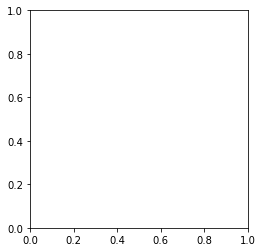

In [2]:
plt.figure()
plt.imshow(image)

In [3]:
print(image)

None


In [11]:
if image is None:
    print('Hello World!')

Hello World!


In [9]:
type(image)

NoneType